# Trabajo Práctico 1: Métricas custom para reducción de falsos positivos en clasificación binaria fraude

## Feature Engineering

Como la función a optimizar es `Detectar fraudes en regiones con alta incidencia histórica`, hay que encontrar nuevas características que puedan ayudar a mejorar el modelo.

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

In [27]:
dataset = pd.read_csv("data/dataset_feature_engineering.csv")
dataset.head()

,cc_num,merchant,category,amt,first,last,gender,street,city,state,...,first_time_at_merchant,dist_between_client_and_merch,trans_month,trans_day,hour,year,times_shopped_at_merchant,times_shopped_at_merchant_year,times_shopped_at_merchant_month,times_shopped_at_merchant_day
0,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,...,True,78.773821,1,1,0,2019,5,4,2,1
1,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,...,True,30.216618,1,1,0,2019,4,4,1,1
2,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,ID,...,True,108.102912,1,1,0,2019,4,3,1,1
3,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,MT,...,True,95.685115,1,1,0,2019,1,1,1,1
4,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,VA,...,True,77.702395,1,1,0,2019,6,1,1,1


### Regionales

Características basadas en las columnas `zip`, `state`, `city` y `lat/long`

In [28]:
fraud_rate_by_zip = dataset.groupby("zip")["is_fraud"].mean()  # Proporción de fraudes por zip
dataset["fraud_rate_by_zip"] = dataset["zip"].map(fraud_rate_by_zip)

In [29]:
fraud_rate_by_city = dataset.groupby("city")["is_fraud"].mean()  # Proporción de fraudes por ciudad
dataset["fraud_rate_by_city"] = dataset["city"].map(fraud_rate_by_city)

In [30]:
fraud_rate_by_state = dataset.groupby("state")["is_fraud"].mean()  # Proporción de fraudes por estado
dataset["fraud_rate_by_state"] = dataset["state"].map(fraud_rate_by_state)

In [31]:
fraud_count_by_city = dataset.groupby("city")["is_fraud"].sum()  # Número total de fraudes históricamente por ciudad
dataset["city_fraud_count"] = dataset["city"].map(fraud_count_by_city)

In [32]:
dataset.head()

,cc_num,merchant,category,amt,first,last,gender,street,city,state,...,hour,year,times_shopped_at_merchant,times_shopped_at_merchant_year,times_shopped_at_merchant_month,times_shopped_at_merchant_day,fraud_rate_by_zip,fraud_rate_by_city,fraud_rate_by_state,city_fraud_count
0,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,...,0,2019,5,4,2,1,0.003758,0.003758,0.004521,11
1,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,...,0,2019,4,4,1,1,0.001605,0.002160,0.004660,11
2,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,ID,...,0,2019,4,3,1,1,0.010884,0.010884,0.004107,8
3,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,MT,...,0,2019,1,1,1,1,0.020188,0.020188,0.004106,15
4,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,VA,...,0,2019,6,1,1,1,0.004449,0.004449,0.006538,13


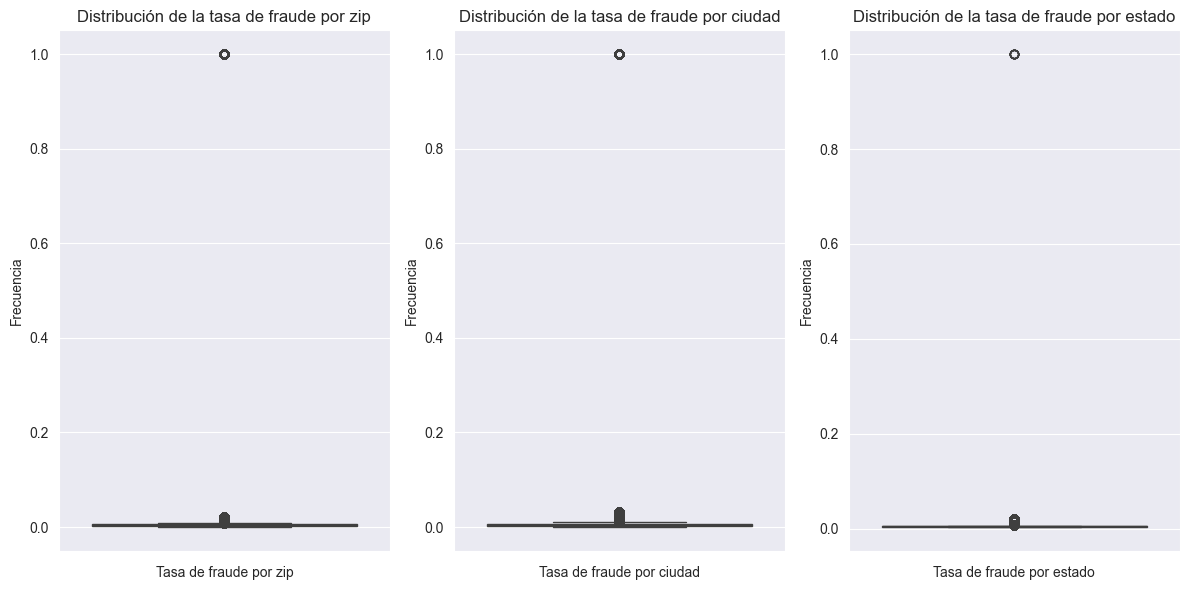

In [41]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
sns.boxplot(dataset["fraud_rate_by_zip"])
plt.title("Distribución de la tasa de fraude por zip")
plt.xlabel("Tasa de fraude por zip")
plt.ylabel("Frecuencia")

plt.subplot(1, 3, 2)
sns.boxplot(dataset["fraud_rate_by_city"])
plt.title("Distribución de la tasa de fraude por ciudad")
plt.xlabel("Tasa de fraude por ciudad")
plt.ylabel("Frecuencia")

plt.subplot(1, 3, 3)
sns.boxplot(dataset["fraud_rate_by_state"])
plt.title("Distribución de la tasa de fraude por estado")
plt.xlabel("Tasa de fraude por estado")
plt.ylabel("Frecuencia")

plt.tight_layout()
plt.show()

### Temporales y Regionales

Características basadas en las columnas `zip`, `state`, `city` y `lat/long` y columnas como `trans_month`, `trans_day`, `hour` y `year`

In [34]:
monthly_zip_fraud = dataset.groupby(["zip", "trans_month"])["is_fraud"].mean()  # Proporción de fraudes por zip y mes
dataset["monthly_zip_fraud_rate"] = dataset.set_index(["zip", "trans_month"]).index.map(monthly_zip_fraud)

In [35]:
dataset.sort_values(by=["zip", "unix_time"], inplace=True)
# Rate de fraude por zip y mes, considerando los últimos 100 registros
dataset["rolling_fraud_rate_by_zip"] = (
    dataset.groupby("zip")["is_fraud"].transform(lambda x: x.rolling(window=100, min_periods=1).mean())
)

In [36]:
dataset.head()

,cc_num,merchant,category,amt,first,last,gender,street,city,state,...,times_shopped_at_merchant,times_shopped_at_merchant_year,times_shopped_at_merchant_month,times_shopped_at_merchant_day,fraud_rate_by_zip,fraud_rate_by_city,fraud_rate_by_state,city_fraud_count,monthly_zip_fraud_rate,rolling_fraud_rate_by_zip
1514,6011399591920186,fraud_Lubowitz-Walter,kids_pets,48.43,Maria,Roy,F,58665 Nicholas Ford Suite 348,Sheffield,MA,...,4,2,1,2,0.003079,0.003079,0.004954,9,0.0,0.0
2491,6011399591920186,fraud_Kunde-Sanford,misc_net,1.58,Maria,Roy,F,58665 Nicholas Ford Suite 348,Sheffield,MA,...,3,2,1,1,0.003079,0.003079,0.004954,9,0.0,0.0
4762,6011399591920186,fraud_Fisher Inc,shopping_net,6.10,Maria,Roy,F,58665 Nicholas Ford Suite 348,Sheffield,MA,...,3,2,1,1,0.003079,0.003079,0.004954,9,0.0,0.0
6043,6011399591920186,fraud_Quitzon-Goyette,home,8.42,Maria,Roy,F,58665 Nicholas Ford Suite 348,Sheffield,MA,...,8,4,1,1,0.003079,0.003079,0.004954,9,0.0,0.0
6499,6011399591920186,fraud_Huels-Nolan,gas_transport,31.53,Maria,Roy,F,58665 Nicholas Ford Suite 348,Sheffield,MA,...,8,4,2,3,0.003079,0.003079,0.004954,9,0.0,0.0


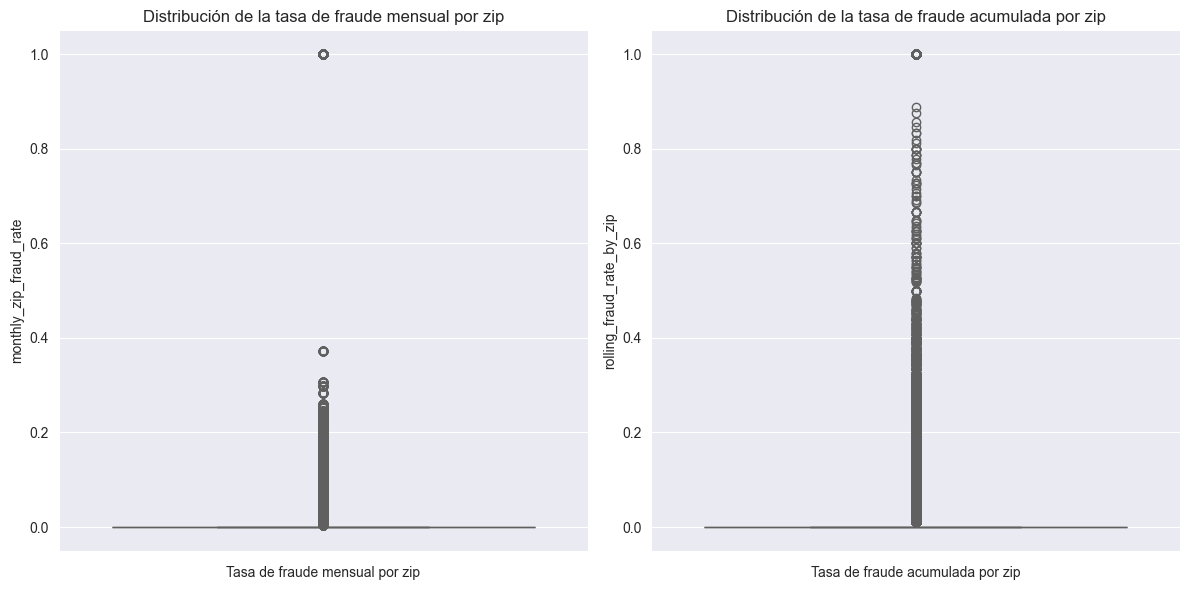

In [37]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.boxplot(dataset["monthly_zip_fraud_rate"], palette="Blues")
plt.title("Distribución de la tasa de fraude mensual por zip")
plt.xlabel("Tasa de fraude mensual por zip")

plt.subplot(1, 2, 2)
sns.boxplot(dataset["rolling_fraud_rate_by_zip"], palette="Blues")
plt.title("Distribución de la tasa de fraude acumulada por zip")
plt.xlabel("Tasa de fraude acumulada por zip")
plt.tight_layout()
plt.show()

### Geolocalización

In [38]:
# Densidad de transacciones por región
dataset["lat_bin"] = pd.cut(dataset["lat"], bins=50)
dataset["long_bin"] = pd.cut(dataset["long"], bins=50)
region_density = dataset.groupby(["lat_bin", "long_bin"])["trans_num"].count()
dataset["region_density"] = dataset.set_index(["lat_bin", "long_bin"]).index.map(region_density)

In [39]:
dataset.head()

,cc_num,merchant,category,amt,first,last,gender,street,city,state,...,times_shopped_at_merchant_day,fraud_rate_by_zip,fraud_rate_by_city,fraud_rate_by_state,city_fraud_count,monthly_zip_fraud_rate,rolling_fraud_rate_by_zip,lat_bin,long_bin,region_density
1514,6011399591920186,fraud_Lubowitz-Walter,kids_pets,48.43,Maria,Roy,F,58665 Nicholas Ford Suite 348,Sheffield,MA,...,2,0.003079,0.003079,0.004954,9,0.0,0.0,"(41.494, 42.427]","(-73.814, -71.859]",18308
2491,6011399591920186,fraud_Kunde-Sanford,misc_net,1.58,Maria,Roy,F,58665 Nicholas Ford Suite 348,Sheffield,MA,...,1,0.003079,0.003079,0.004954,9,0.0,0.0,"(41.494, 42.427]","(-73.814, -71.859]",18308
4762,6011399591920186,fraud_Fisher Inc,shopping_net,6.10,Maria,Roy,F,58665 Nicholas Ford Suite 348,Sheffield,MA,...,1,0.003079,0.003079,0.004954,9,0.0,0.0,"(41.494, 42.427]","(-73.814, -71.859]",18308
6043,6011399591920186,fraud_Quitzon-Goyette,home,8.42,Maria,Roy,F,58665 Nicholas Ford Suite 348,Sheffield,MA,...,1,0.003079,0.003079,0.004954,9,0.0,0.0,"(41.494, 42.427]","(-73.814, -71.859]",18308
6499,6011399591920186,fraud_Huels-Nolan,gas_transport,31.53,Maria,Roy,F,58665 Nicholas Ford Suite 348,Sheffield,MA,...,3,0.003079,0.003079,0.004954,9,0.0,0.0,"(41.494, 42.427]","(-73.814, -71.859]",18308


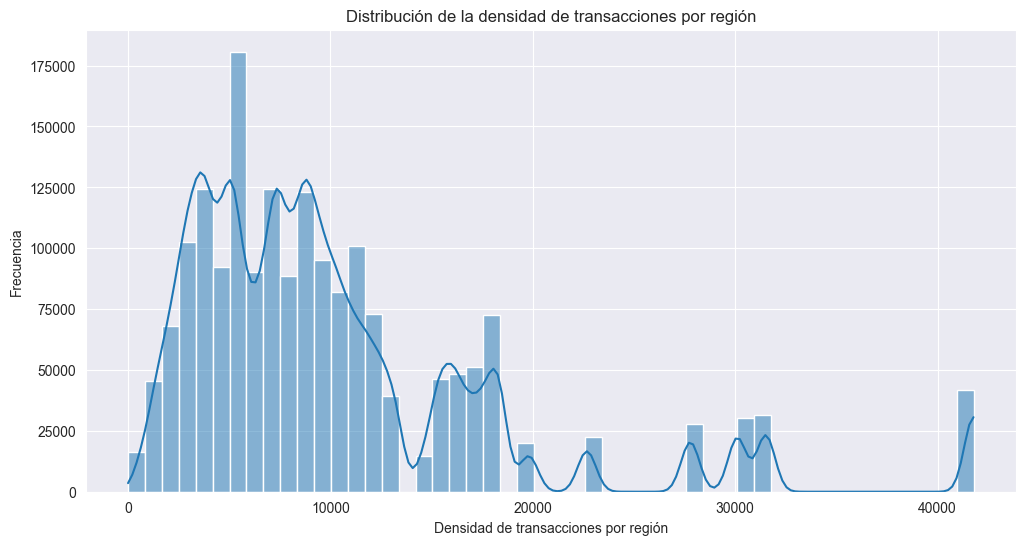

In [40]:
plt.figure(figsize=(12, 6))
sns.histplot(dataset["region_density"], bins=50, kde=True)
plt.title("Distribución de la densidad de transacciones por región")
plt.xlabel("Densidad de transacciones por región")
plt.ylabel("Frecuencia")
plt.show()

## Resumen de variables creadas

### Regionales

- `fraud_rate_by_zip`: Proporción de fraudes por zip
- `fraud_rate_by_city`: Proporción de fraudes por ciudad
- `fraud_rate_by_state`: Proporción de fraudes por estado
- `city_fraud_count`: Número total de fraudes históricamente por ciudad

> Con estos rates es posible que, usando un umbral, hacer otra característica que clasifique como "en peligro" o no en base si el rate supera un umbral. Por ejemplo, si el rate es mayor al 10% se puede clasificar como "en peligro" y si es menor al 10% como "no en peligro". Esto podría ayudar a reducir los falsos positivos. Lo probaré con el modelo más adelante

### Temporales y Regionales

- `monthly_zip_fraud_rate`: Proporción de fraudes por zip y mes
- `rolling_fraud_rate_by_zip`: Tasa de fraude por zip y mes, considerando los últimos 100 registros

### Geolocalización

- `region_density`: Densidad de transacciones por región